# Pollution azotée


* CC de géochimie environnementale, M1 ACSC et HR, 2018-2019
* Soumis aux étudiants le 29/10/2018

**Il est conseillé de faire une copie de ce notebook avant toute modification. D'une façon générale, des sauvegardes régulières au cours du travail sont souhaitables.**

Ce notebook doit être complété autant que possible, puis :

* renommé pour éviter les erreurs
* renvoyé par e-mail à Emmanuel.Cosme@univ-grenoble-alpes.fr avant le **23 novembre 2018**

Le travail peut-être accompli individuellement ou par groupes de 4 au maximum. Dans le cas d'un travail en groupe, il est possible que l'un ou plusieurs des participants soit interrogés "par surprise" sur ce travail.

Pour toute question de compréhension du problème, venez me voir en séance ou contactez-moi par e-mail.

## Participants à ce notebook :

* Lisa Bouvet
* 
* 
* 

## Introduction

Les combustions anthropiques urbaines émettent des oxydes d'azote ($NOx$) en grande quantité. Lors de votre première mission (TP 1-4), vous avez développé un outil permettant aux responsables politiques d'évaluer quelle fraction de ce qui est émis par l'industrie française est transporté par le vent vers l'Allemagne. Nous pouvons alors adopter des mesures politiques quantifiables pour conserver nos bonnes relations diplomatiques.

Mais aujourd'hui, ce sont les Français qui grognent. Puisqu'on leur a dit que les $NOx$ et son principal produit d'oxydation, le $HNO_3$, ne vont pas trop en Allemagne, c'est donc qu'ils restent en France, provoquant des problèmes de santé et de pollution des sols par leur dépôt.

Vous avez rempli votre première mission avec brio, aussi le ministère souhaite que vous vous remettiez à la tâche pour reprendre l'étude et quantifier plus précisément le cycle des $NOx$ et $HNO_3$ dans l'air que respirent nos compatriotes.

Vous voici donc missionnés pour développer un modèle numérique permettant de représenter le cycle de ces composés, en particulier dans la dimension verticale, entre la couche limite atmosphérique (CLA, d'une épaisseur de 1000 m environ) où l'on respire, et la troposphère libre (TL) où la circulation de grande échelle plus intense a tendance à exporter les composés chimiques (vers l'Allemagne, peut-être). Le problème n'est pas simple car beaucoup de paramètres (temps de vie chimiques, échanges entre CLA et TL, émissions) dépendent de l'heure. Vous faites le choix d'un modèle à 2 boîtes (CLA et TL) et vous vous préparez à résoudre le problème progressivement, en introduisant les difficultés par étapes.




## Importation de modules utiles

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
import pandas as pd
%matplotlib inline

## 1. Prise en main : modélisation simplifiée
On commence par développer un modèle sans tenir compte des variations temporelles. On prendra par exemple les valeurs suivantes :

- Emission de $NOx$ : 40 T/jour
- temps de vie chimique (le $NOx$ est oxydé en $HNO_3$) :
    - $NOx$ dans la CLA : 5 h
    - $NOx$ dans la TL : 5 j
    - $HNO_3$ dans la CLA : 100 j
    - $HNO_3$ dans la TL : 200 j
- vitesse de dépôt sec au sol :
    - $NOx$ : 0.2 cm/s
    - $HNO_3$ : 1.5 cm/s
- temps de vie lié au transport par le vent hors du système, **dans la TL seulement** :
    - $NOx$ et $HNO3$ : 14 j
- temps de vie lié au transport de la CLA vers la TL :
    - $NOx$ et $HNO3$ : 3 j
- temps de vie lié au transport de la TL vers la CLA :
    - $NOx$ et $HNO3$ : 10 j
    
### Question :
Dans des cellules ci-dessous, coder un modèle numérique permettant de calculer les évolutions temporelles des composés $NOx$ et $HNO_3$ dans les compartiments atmosphériques CLA et TL. En initialisant le système avec des masses de composés à 0, combien faut-il de jours (environ) pour atteindre un équilibre ? Tracer les évolutions temporelles des composés sur 4 jours lorsque cet équilibre est atteint.

_L'intégration temporelle sera calculée avec un schéma de Runge-Kutta d'ordre 4. Le code sera aussi clair et compact que possible (donc, avec une fonction, comme en TP...). Il sera également commenté de manière à le rendre facilement lisible par un utilisateur extérieur (ou un professeur chargé d'évaluer le travail...)_

In [24]:
# Parametres
ino = 0    # indice $NOx$
ihn = 1    # indice $HNO_3$
jcl = 0    # indice CLA
jtl = 1    # indice TL

## Emissions
Enox = 40. / 24     # emission T/h

## Depots, avec une hauteur de CLA de 1000 m
hcla = 1000.    # m
vdep = np.zeros(2)
vdep[ino] = 0.2*3600*0.1/hcla   # en /h , vdep=D/hcla
vdep[ihn] = 1.5*0.1*3600/(hcla)   # en /h

## Chimie
kchim = np.zeros((2,2))
kchim[ino, jcl] = 1./(5.)      #en /h
kchim[ino, jtl] = 1./(5.*24.)
kchim[ihn, jcl] = 1./(100.*24.)
kchim[ihn, jtl] = 1./(200.*24.)

## Transport
kexptl = 1./(14.*24.)    #en /h
kcla2tl = 1./(3.*24.)
ktl2cla = 1./(10.*24.)

In [25]:
# ???

Text(0.5, 1.0, 'Evolutions temporelles des composés')

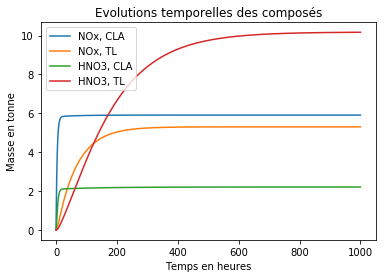

In [29]:
# Initialisation
mass = np.zeros((2,2))
dt = 1. # en h
nt = 1000  # nb pas de temps
mass_series = np.zeros((2,2,nt+1))
mass_series[:,:,0] = mass

#Coefficients pour la méthode RK4            #les k sont des matrices 2x2 dont les indicent correspondent à ceux de mass
k_1=np.zeros((2,2))
k_2=np.zeros((2,2))
k_3=np.zeros((2,2))
k_4=np.zeros((2,2))

#Fonction right hand side, équations de conservation de la masse pour les 2 composés dans les 2 compartiments
def rhs(conc_in):
    conc_out=np.zeros((2,2))
    conc_out[ino,jcl]=Enox+conc_in[ino,jtl]*ktl2cla-conc_in[ino,jcl]*kcla2tl-conc_in[ino,jcl]*kchim[ino,jcl]-conc_in[ino,jcl]*vdep[ino]
    conc_out[ino,jtl]=conc_in[ino,jcl]*kcla2tl-conc_in[ino,jtl]*ktl2cla-conc_in[ino,jtl]*kchim[ino,jtl]-conc_in[ino,jtl]*kexptl
    conc_out[ihn,jcl]=conc_in[ihn,jtl]*ktl2cla-conc_in[ihn,jcl]*kcla2tl-conc_in[ihn,jcl]*kchim[ihn,jcl]-conc_in[ihn,jcl]*vdep[ihn]+conc_in[ino,jcl]*kchim[ino,jcl]
    conc_out[ihn,jtl]=conc_in[ihn,jcl]*kcla2tl-conc_in[ihn,jtl]*ktl2cla-conc_in[ihn,jtl]*kchim[ihn,jtl]-conc_in[ihn,jtl]*kexptl+conc_in[ino,jtl]*kchim[ino,jtl]
    return conc_out

# Time integration, méthode de RK4
for it in range(nt):
    k_1=rhs(mass)
    k_2=rhs(mass+k_1*(dt/2.))
    k_3=rhs(mass+k_2*(dt/2.))
    k_4=rhs(mass+k_3*dt)
    mass=mass + dt * ((k_1+2*k_2+2*k_3+k_4)/6)
    mass_series[:,:,it+1] = mass

# Plots
plt.plot(mass_series[0,0,:], label='NOx, CLA')
plt.plot(mass_series[0,1,:], label='NOx, TL')
plt.plot(mass_series[1,0,:], label='HNO3, CLA')
plt.plot(mass_series[1,1,:], label='HNO3, TL')
plt.legend()
plt.ylabel('Masse en tonne')
plt.xlabel('Temps en heures')
plt.title('Evolutions temporelles des composés')

In [30]:
# Il faut environ 800h soit environ un mois pour qu'un équilibre soit atteint

Text(0.5, 1.0, 'Evolutions temporelles sur les 4 derniers jours de la simulation')

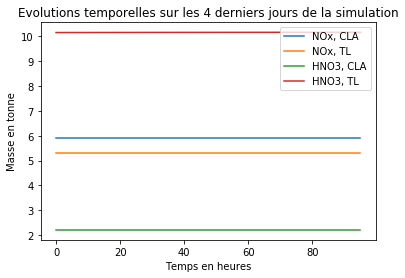

In [31]:
# Plots sur les 4 derniers jours de la simulation
ij4 = int(4*24/dt)    # nombre d'indices pour couvrir 4 jours
plt.plot(mass_series[0,0,nt-ij4:nt], label='NOx, CLA')
plt.plot(mass_series[0,1,nt-ij4:nt], label='NOx, TL')
plt.plot(mass_series[1,0,nt-ij4:nt], label='HNO3, CLA')
plt.plot(mass_series[1,1,nt-ij4:nt], label='HNO3, TL')
plt.legend()
plt.ylabel('Masse en tonne')
plt.xlabel('Temps en heures')
plt.title('Evolutions temporelles sur les 4 derniers jours de la simulation')

## 2. Variations temporelles des différents paramètres

Les résultats précédents ne vous satisfont pas car les niveaux de $HNO_3$ vous semblent bien plus élevés que dans la réalité. Votre expérience vous laissent penser qu'en tenant compte des variations temporelles des différents paramètres de façon réaliste, vous améliorerez sensiblement vos résultats. Les données que vous avez pour vous guider sont les suivantes :

#### Emissions
La quantité quotidienne totale est identique à précédemment, mais est à 0 la nuit, entre 20 h et 8 h. Le jour, elle est supposée constante entre 8 h et 20 h (dont de 80 T/j)

#### Dépôts secs
Les valeurs précédentes restent valables, constantes au cours de la journée.

#### Chimie
Le temps de vie des composés est environ 5 fois supérieur la nuit que le jour. Le jour, les temps de vie des $NOx$ sont d'environ 3 h et 3.5 jours dans la CLA et la TL, respectivement. Pour le $HNO_3$, on ne sait pas trop, on laisse comme c'est.

#### Transport
Pour le transport, c'est un peu plus compliqué car cela met en jeu la dynamique de la couche limite. Vous décidez de traiter cela dans une prochaine étape.

### Question :
Dans la cellule ci-dessous, coder des fonctions _emission_ et _chemistry_ qui prennent en variables d'entrée un temps (en heure), et calculent l'émission de $NOx$ et les constantes chimiques en sortie, respectivement. Tracer ces variables sur une journée.

In [95]:
def creneau(T,nt,Borne_jour, Borne_nuit): #Définition de la fonction créneau en utilisant un signal périodique sinusoïdal
    creneau=np.zeros(nt)
    y=np.sin((2*np.pi/(T-1))*(np.arange(nt)-8))
    for i in range(nt):
        if y[i]<=0:
            creneau[i]=Borne_nuit
        else:
            creneau[i]=Borne_jour
    return creneau

Text(0, 0.5, 'Emission de NO en tonnes')

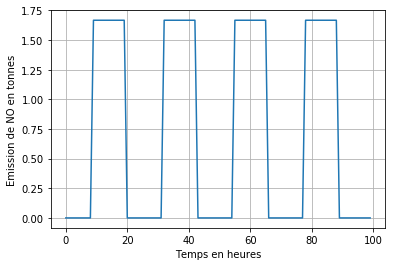

In [96]:
Enox_t=creneau(24,nt,Enox,0)
plt.plot(Enox_t)
plt.grid()
plt.xlabel('Temps en heures')
plt.ylabel('Emission de NO en tonnes')

#Plot

In [112]:
def chemistry(time_in_hours): #kchim qui varie temporellement est maintenant une matrice 3D 2x2xtime_in_hours
    kc=np.zeros(((2,2,time_in_hours)))
    kc[ino,jcl]=creneau(24,time_in_hours,(1/3),1/(5*3))
    kc[ino,jtl]=creneau(24,time_in_hours,1/(3.5*24),1/(5*3.5*24))
    return kc

Text(0, 0.5, 'Emission de NO dans la TL en tonnes')

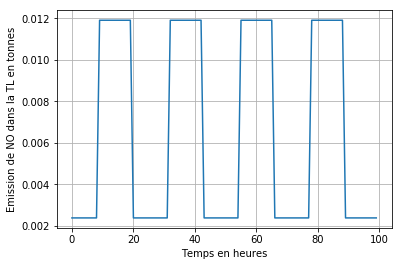

In [130]:
plt.plot(chemistry(100)[ino,jtl])
plt.grid()
plt.xlabel('Temps en heures')
plt.ylabel('Emission de NO dans la TL en tonnes')

## 3. Prise en compte des variations temporelles dans la simulation

### Question :
Reprendre le modèle codé précédemment en lui ajoutant les variations temporelles des émissions et des constantes chimiques. En initialisant le système avec des masses de composés à 0, combien faut-il de jours (environ) pour atteindre un équilibre ? Tracer les évolutions temporelles des composés sur 4 jours lorsque cet équilibre est atteint. Les niveaux de $HNO_3$ ont-ils été sensiblement réduits en tenant compte des variations temporelles des émissions et de la chimie ?

In [121]:
kchim_t=chemistry(nt)
kchim_t[ino,jcl,1]

0.06666666666666667

Text(0.5, 1.0, 'Evolutions temporelles des composés')

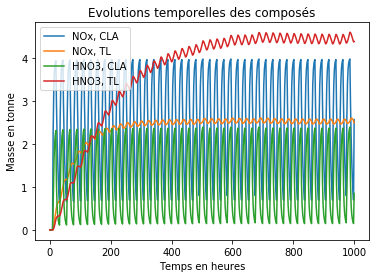

In [169]:
# Initialisation
mass = np.zeros((2,2))
dt = 1. # en h
nt = 1000  # nb pas de temps
mass_series = np.zeros((2,2,nt+1))
mass_series[:,:,0] = mass
kchim_t=chemistry(nt)
Enox_t=creneau(24,nt,Enox,0)
#Coefficients pour la méthode RK4            #les k sont des matrices 2x2 dont les indicent correspondent à ceux de mass
k_1=np.zeros((2,2))
k_2=np.zeros((2,2))
k_3=np.zeros((2,2))
k_4=np.zeros((2,2))

#Fonction right hand side, équations de conservation de la masse pour les 2 composés dans les 2 compartiments
def rhs(conc_in,i):
    conc_out=np.zeros((2,2))
    conc_out[ino,jcl]=Enox_t[i]+conc_in[ino,jtl]*ktl2cla+conc_in[ino,jcl]*(-kcla2tl-kchim_t[ino,jcl,i]-vdep[ino])
    conc_out[ino,jtl]=conc_in[ino,jcl]*kcla2tl+conc_in[ino,jtl]*(-ktl2cla-kchim_t[ino,jtl,i]-kexptl)
    conc_out[ihn,jcl]=conc_in[ihn,jtl]*ktl2cla+conc_in[ihn,jcl]*(-kcla2tl-kchim[ihn,jcl]-vdep[ihn])+conc_in[ino,jcl]*kchim_t[ino,jcl,i]
    conc_out[ihn,jtl]=conc_in[ihn,jcl]*kcla2tl+conc_in[ihn,jtl]*(-ktl2cla-kchim[ihn,jtl]-kexptl)+conc_in[ino,jtl]*kchim_t[ino,jtl,i]
    return conc_out

# Time integration, méthode de RK4
for it in range(nt):
    k_1=rhs(mass,it)
    k_2=rhs(mass+k_1*(dt/2.),it)
    k_3=rhs(mass+k_2*(dt/2.),it)
    k_4=rhs(mass+k_3*dt,it)
    mass=mass + dt * ((k_1+2*k_2+2*k_3+k_4)/6)
    mass_series[:,:,it+1] = mass

# Plots
plt.plot(mass_series[0,0,:], label='NOx, CLA')
plt.plot(mass_series[0,1,:], label='NOx, TL')
plt.plot(mass_series[1,0,:], label='HNO3, CLA')
plt.plot(mass_series[1,1,:], label='HNO3, TL')
plt.legend()
plt.ylabel('Masse en tonne')
plt.xlabel('Temps en heures')
plt.title('Evolutions temporelles des composés')


### Réponse sur l'atteinte de l'équilibre :
???

Text(0.5, 1.0, 'Evolutions temporelles sur les 4 derniers jours de la simulation')

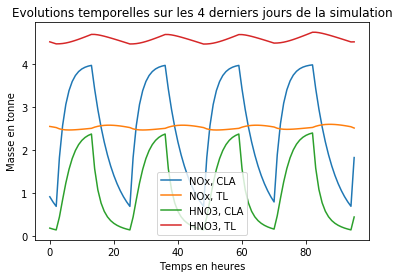

In [150]:
# Plots sur les 4 derniers jours de la simulation
ij4 = int(4*24/dt)    # nombre d'indices pour couvrir 4 jours
plt.plot(mass_series[0,0,nt-ij4:nt], label='NOx, CLA')
plt.plot(mass_series[0,1,nt-ij4:nt], label='NOx, TL')
plt.plot(mass_series[1,0,nt-ij4:nt], label='HNO3, CLA')
plt.plot(mass_series[1,1,nt-ij4:nt], label='HNO3, TL')
plt.legend()
plt.ylabel('Masse en tonne')
plt.xlabel('Temps en heures')
plt.title('Evolutions temporelles sur les 4 derniers jours de la simulation')


### Réponse sur les niveaux de $HNO_3$:


## 4. Le lessivage par la pluie

Quelques discussions avec des collègues à la pause-café vous incite à penser qu'un processus important, puits de $HNO_3$, est le lessivage par la pluie. Effectivement, quand la pluie se forme dans le nuage ou quand elle tombe vers le sol, elle dissout une partie des acides présents dans l'atmosphère. Vous vous attelez donc à la tâche d'introduire ce processus dans votre modèle. Vous faites les hypothèses suivantes :

- Chaque jour, il y a une chance sur 5 pour qu'il pleuve ;
- le temps de vie du $HNO_3$ quand il pleut est de 30 minutes dans la TL, 1 h dans la CLA. En effet, dans la TL il y a du lessivage dans le nuage (_in-cloud scavenging_) et sous le nuage (_below-cloud scavenging_). Dans la CLA, il n'y a pas de _in-cloud_.

### Question

Coder une fonction qui détermine s'il pleut ou non de façon aléatoire, et sort un booléen valant True s'il pleut, et False s'il ne pleut pas. 
Reprendre alors le modèle complet en y introduisant le lessivage de $HNO_3$. Quelles concentrations de composés sont sensiblement affectées par ce nouveau processus ?

_On fera attention dans le schéma de Runge-Kutta : s'il pleut à un temps donné, il faut en tenir compte à chaque appel de la fonction... On réfléchira bien aux arguments nécessaires à la fonction de pluie._

In [152]:
# La fonction suivante permet de tirer un nombre aléatoire réel dans l'intervalle [0,1]:
np.random.random()

0.13850923979133734

In [153]:
# Fonction pluie
def Pluie():
    if np.random.random()<=(1/5.):
        Pluie=True
    else:
        Pluie=False
    return Pluie

22

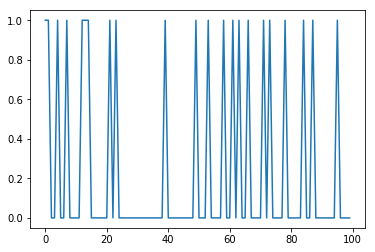

In [164]:
#Test de la fonction
Test=np.zeros(100)
x=0
for i in range(100):
    Test[i]=Pluie()
    if Test[i]==True:
        x=x+1
plt.plot(Test)
x

In [170]:
if Pluie()==True:
    kchim_t[ihn,jcl]=1
    kchim_t[ihn,jtl]=2
else:
    kchim[ihn, jcl] = 1./(100.*24.)
    kchim[ihn, jtl] = 1./(200.*24.)

Text(0.5, 1.0, 'Evolutions temporelles des composés')

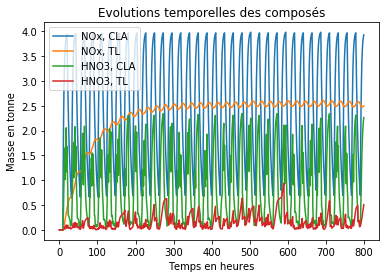

In [175]:
# Initialisation
mass = np.zeros((2,2))
dt = 1. # en h
nt = 800  # nb pas de temps
mass_series = np.zeros((2,2,nt+1))
mass_series[:,:,0] = mass
kchim_t=chemistry(nt)
Enox_t=creneau(24,nt,Enox,0)

#Pluie
for i in range(nt):
    if Pluie()==True:
        kchim_t[ihn,jcl,i]=1
        kchim_t[ihn,jtl,i]=2
    else:
        kchim_t[ihn, jcl,i] = 1./(100.*24.)
        kchim_t[ihn, jtl,i] = 1./(200.*24.)

#Coefficients pour la méthode RK4            #les k sont des matrices 2x2 dont les indicent correspondent à ceux de mass
k_1=np.zeros((2,2))
k_2=np.zeros((2,2))
k_3=np.zeros((2,2))
k_4=np.zeros((2,2))

#Fonction right hand side, équations de conservation de la masse pour les 2 composés dans les 2 compartiments
def rhs(conc_in,i):
    conc_out=np.zeros((2,2))
    conc_out[ino,jcl]=Enox_t[i]+conc_in[ino,jtl]*ktl2cla-conc_in[ino,jcl]*kcla2tl-conc_in[ino,jcl]*kchim_t[ino,jcl,i]-conc_in[ino,jcl]*vdep[ino]
    conc_out[ino,jtl]=conc_in[ino,jcl]*kcla2tl-conc_in[ino,jtl]*ktl2cla-conc_in[ino,jtl]*kchim_t[ino,jtl,i]-conc_in[ino,jtl]*kexptl
    conc_out[ihn,jcl]=conc_in[ihn,jtl]*ktl2cla-conc_in[ihn,jcl]*kcla2tl-conc_in[ihn,jcl]*kchim_t[ihn,jcl,i]-conc_in[ihn,jcl]*vdep[ihn]+conc_in[ino,jcl]*kchim_t[ino,jcl,i]
    conc_out[ihn,jtl]=conc_in[ihn,jcl]*kcla2tl-conc_in[ihn,jtl]*ktl2cla-conc_in[ihn,jtl]*kchim_t[ihn,jtl,i]-conc_in[ihn,jtl]*kexptl+conc_in[ino,jtl]*kchim_t[ino,jtl,i]
    return conc_out

# Time integration, méthode de RK4
for it in range(nt):
    k_1=rhs(mass,it)
    k_2=rhs(mass+k_1*(dt/2.),it)
    k_3=rhs(mass+k_2*(dt/2.),it)
    k_4=rhs(mass+k_3*dt,it)
    mass=mass + dt * ((k_1+2*k_2+2*k_3+k_4)/6)
    mass_series[:,:,it+1] = mass

# Plots
plt.plot(mass_series[0,0,:], label='NOx, CLA')
plt.plot(mass_series[0,1,:], label='NOx, TL')
plt.plot(mass_series[1,0,:], label='HNO3, CLA')
plt.plot(mass_series[1,1,:], label='HNO3, TL')
plt.legend()
plt.ylabel('Masse en tonne')
plt.xlabel('Temps en heures')
plt.title('Evolutions temporelles des composés')

Text(0.5, 1.0, 'Evolutions temporelles sur les 4 derniers jours de la simulation')

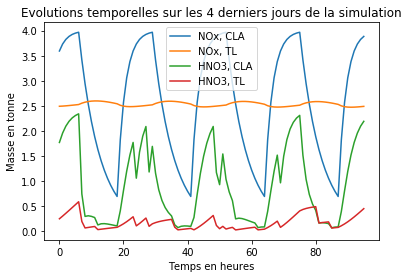

In [176]:
# Plots sur les 4 derniers jours de la simulation
ij4 = int(4*24/dt)    # nombre d'indices pour couvrir 4 jours
plt.plot(mass_series[0,0,nt-ij4:nt], label='NOx, CLA')
plt.plot(mass_series[0,1,nt-ij4:nt], label='NOx, TL')
plt.plot(mass_series[1,0,nt-ij4:nt], label='HNO3, CLA')
plt.plot(mass_series[1,1,nt-ij4:nt], label='HNO3, TL')
plt.legend()
plt.ylabel('Masse en tonne')
plt.xlabel('Temps en heures')
plt.title('Evolutions temporelles sur les 4 derniers jours de la simulation')



## 5. Analyse statistique

### Question :
Maintenant, il faut rendre compte au ministère : trouver une démarche pour répondre à ces deux questions :

* Quelles sont les quantités moyennes de chaque composé dans chaque boîte ?
* Pendant combien de jours (en cumulé) dans l'année la masse de $HNO_3$ dans la CLA dépasse le seuil fatidique de 30 ?

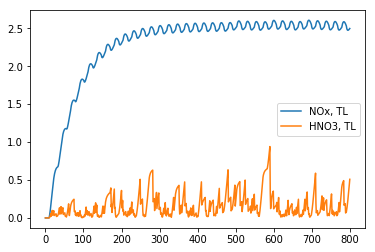

In [180]:
plt.plot(mass_series[0,1,:], label='NOx, TL')
plt.plot(mass_series[1,1,:], label='HNO3, TL')
plt.legend()